In [1]:
from keras.datasets import fashion_mnist
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import KFold
from keras.optimizers import SGD
from IPython.display import Image, display

Using TensorFlow backend.


**Load Dataset and Preprocess**

4423680/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


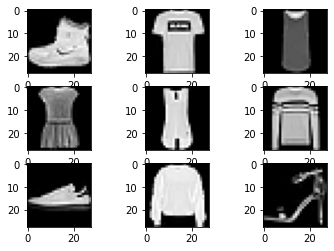

In [2]:
# load dataset and visualize
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [0]:
# reshape data for keras
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [0]:
# OHE targets
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [0]:
# Split training set for model selection and to compute learning curves
X_train1 = X_train[:10000]
y_train1 = y_train[:10000]

**Define Models - Vanilla, Dropout, and Batch Normalization**

In [0]:
# define cnn model - "Vanilla"
def define_vanilla_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(784, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
# model using dropout
def define_dropout_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(784, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.6))
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.4))
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [0]:
# model using batch normalization
def define_batch_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(784, activation='relu', kernel_initializer='he_uniform', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))

  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

**Train and Evaluate Models**

In [0]:
# Define function for training/evaluation
def train_and_evaluate_model(model_type, X, y, num_epochs=25, batch_size=32, callbacks=None):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(5, shuffle=True, random_state=1)
    for train, val in kfold.split(X):
      # define model
      if model_type == 'vanilla':
        model = define_vanilla_model()
      elif model_type == 'dropout':
        model = define_dropout_model()
      else:
        model = define_batch_model()
      # select rows for train and test
      X_train, y_train, X_val, y_val = X[train], y[train], X[val], y[val]
      # fit model
      history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
      # evaluate model
      loss, acc = model.evaluate(X_val, y_val, verbose=0)
      print('Accuracy: %.3f' % (acc * 100.0))
      # append scores
      scores.append(acc)
      histories.append(history)
      del model
    return scores, histories

**Visualize**

In [0]:
# Define function for plotting learning curve
def summarize_diagnostics(histories, title):
  for i in range(len(histories)):
    # plot accuracy
    plt.title('Classification Accuracy: ' + title)
    plt.plot(histories[i].history['accuracy'], color='navy', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='firebrick', label='test')
    plt.grid(True)
    if i == 0:
      plt.legend(loc='best')
  plt.xlabel('Ephochs')
  plt.ylabel('Accuracy')
  plt.show()

In [0]:
def compare_plots(histories_1, histories_2, plot_1_title, plot_2_title):
    epochs = range(1, len(histories_1[0].history['accuracy']) + 1)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=((16, 4)))

    # plot accuracies vanilla
    acc_vals = histories_1[0].history['accuracy']
    val_acc_vals = histories_1[0].history['val_accuracy']
    ax[0].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[0].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[0].set_title('Accuracy vs. Epochs: '  + plot_1_title)
    ax[0].legend(loc='best')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].grid(True)

    # plot accuracies dropout
    acc_vals = histories_2[0].history['accuracy']
    val_acc_vals = histories_2[0].history['val_accuracy']
    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Accuracy vs. Epochs: ' + plot_2_title)
    ax[1].legend(loc='best')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)

    plt.show()
    plt.close()
    del epochs, acc_vals, val_acc_vals

Accuracy: 85.200
Accuracy: 85.400
Accuracy: 87.100
Accuracy: 85.850
Accuracy: 86.050


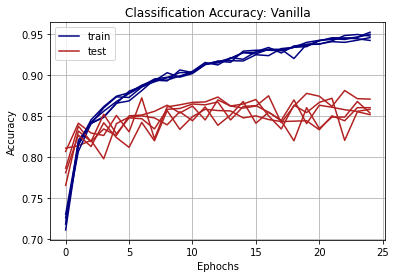

In [13]:
# Train vanilla model
model_type = 'vanilla'
scores, histories_vanilla = train_and_evaluate_model(model_type, X_train1, y_train1)
summarize_diagnostics(histories_vanilla, 'Vanilla')

Accuracy: 84.850
Accuracy: 84.750
Accuracy: 85.750
Accuracy: 84.400
Accuracy: 84.650


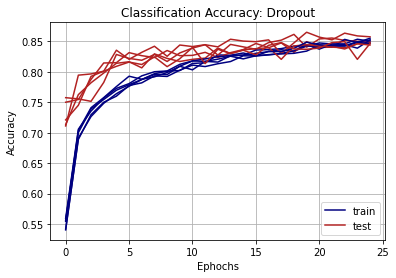

In [14]:
# Train dropout model
model_type = 'dropout'
scores, histories_dropout = train_and_evaluate_model(model_type, X_train1, y_train1)
summarize_diagnostics(histories_dropout, 'Dropout')

Accuracy: 83.150
Accuracy: 84.850
Accuracy: 85.400
Accuracy: 85.500
Accuracy: 83.600


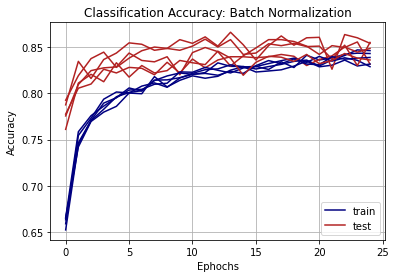

In [15]:
# Train vanilla model
model_type = 'batch'
scores, histories_batch = train_and_evaluate_model(model_type, X_train1, y_train1)
summarize_diagnostics(histories_batch, 'Batch Normalization')

**Compare Models**

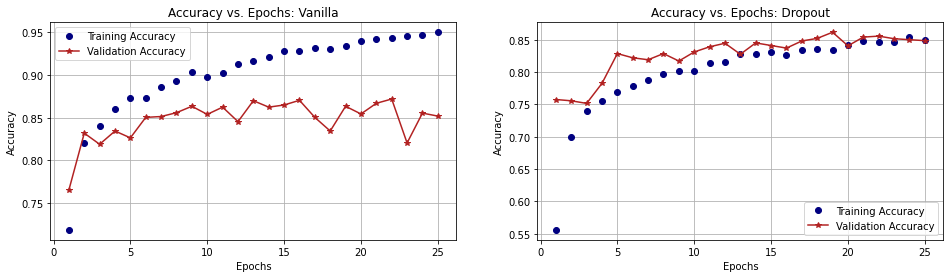

In [16]:
compare_plots(histories_vanilla, histories_dropout, 'Vanilla', 'Dropout')

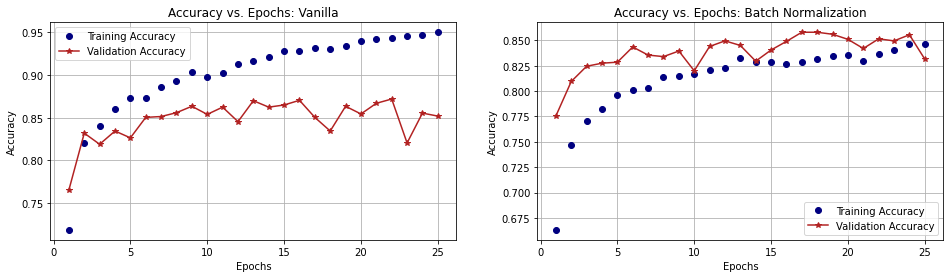

In [17]:
compare_plots(histories_vanilla, histories_batch, 'Vanilla', 'Batch Normalization')